### Time-series data analysis using LSTM (Tutorial)

- https://www.kaggle.com/code/amirrezaeian/time-series-data-analysis-using-lstm-tutorial 

#### 1. package load

In [1]:
import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.model_selection import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score

## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils.np_utils import to_categorical
from tensorflow.keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

#### 2. Data load

- 1) 데이터에 문자열로 'nan'과 '?'이 포함  -> 두 개를 numpy nan으로 변환하여 동일하게 처리
- 2) '날짜'와 '시간' 두 열을 'dt'로 병합
- 3) 데이터를 시간이 되도록 인덱스를 가져와서 시계열 유형으로 변환

In [2]:
df = pd.read_csv('household_power_consumption/household_power_consumption.txt', sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')

In [3]:
df

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
...,...,...,...,...,...,...,...
2010-11-26 20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0
2010-11-26 20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0
2010-11-26 21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


In [5]:
df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [6]:
df.dtypes

Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object

In [7]:
df.shape

(2075259, 7)

In [8]:
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


In [9]:
df.columns

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

- nan 값 처리하기

In [10]:
droping_list_all=[]

for j in range(0,7):
    if not df.iloc[:, j].notnull().all():
        droping_list_all.append(j)        
        print(df.iloc[:,j].unique())
droping_list_all

[4.216 5.36  5.374 ... 9.63  9.648 8.6  ]
[0.418 0.436 0.498 0.502 0.528 0.522 0.52  0.51  0.47  0.478 0.398 0.422
 0.282 0.152 0.156 0.    0.076 0.09  0.2   0.058 0.18  0.144 0.118 0.108
 0.202 0.192 0.186 0.116 0.136 0.148 0.16  0.158 0.1   0.082 0.05  0.052
 0.162 0.086 0.048 0.054 0.068 0.166 0.174 0.178 0.188 0.088 0.08  0.07
 0.084 0.074 0.106 0.092 0.064 0.046 0.138 0.134 0.132 0.12  0.13  0.154
 0.078 0.142 0.14  0.146 0.15  0.17  0.102 0.072 0.06  0.056 0.062 0.112
 0.066 0.172 0.168 0.194 0.184 0.096 0.164 0.182 0.094 0.098 0.176 0.19
 0.204 0.22  0.198 0.208 0.244 0.334 0.298 0.296 0.286 0.278 0.104 0.258
 0.238 0.256 0.214 0.23  0.21  0.24  0.124 0.122 0.27  0.302 0.272 0.25
 0.294 0.3   0.128 0.126 0.234 0.242 0.316 0.28  0.288 0.224 0.11  0.248
 0.254 0.222 0.246 0.216 0.212 0.114 0.206 0.228 0.226 0.196 0.218 0.368
 0.338 0.31  0.304 0.292 0.268 0.266 0.26  0.396 0.38  0.4   0.384 0.416
 0.404 0.382 0.232 0.314 0.312 0.262 0.252 0.236 0.348 0.342 0.34  0.35
 0.504 0.344 

[0, 1, 2, 3, 4, 5, 6]

In [11]:
for j in range(0,7):        
        df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())

In [12]:
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

### 3. Data visualization

- **Global_active_power** 
- 하루 동안 재샘플링하고 Global_active_power의 합과 평균
- 재샘플링된 데이터 집합의 평균과 합은 유사한 구조를 갖는 것으로 보임

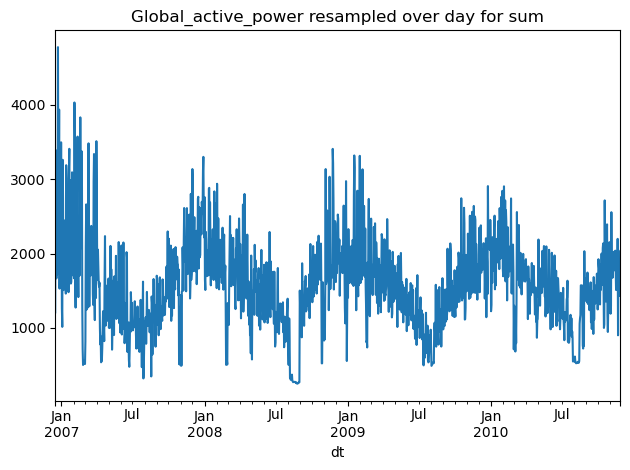

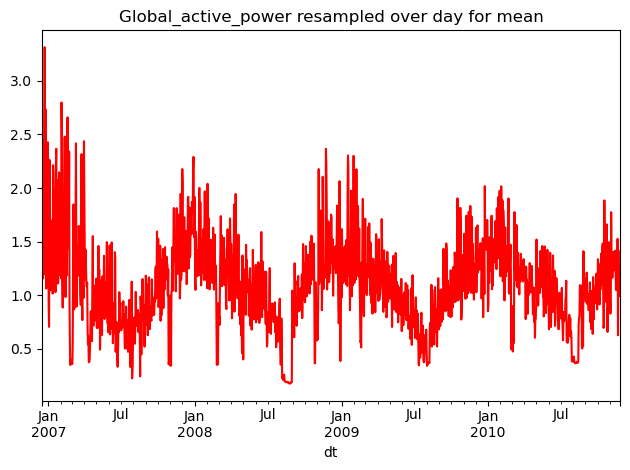

In [13]:
df.Global_active_power.resample('D').sum().plot(title='Global_active_power resampled over day for sum') 
plt.tight_layout()
plt.show()   

df.Global_active_power.resample('D').mean().plot(title='Global_active_power resampled over day for mean', color='red') 
plt.tight_layout()
plt.show()

- 위와 같음

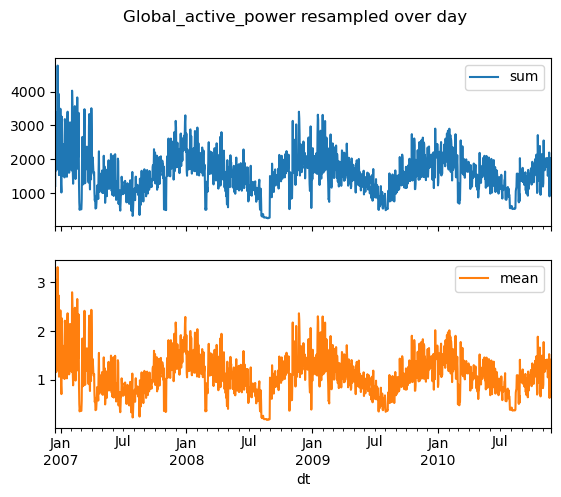

In [15]:
t = df.Global_active_power.resample('D').agg(['sum', 'mean'])

t.plot(subplots = True, title='Global_active_power resampled over day')
plt.show()

- **Global_intensity** 
- 'Global_intensity'의  mean 과 std 가 하루 동안 샘플링된 것

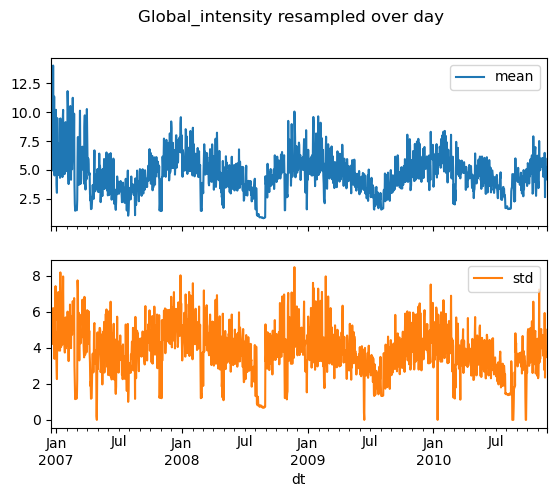

In [16]:
r = df.Global_intensity.resample('D').agg(['mean', 'std'])

r.plot(subplots = True, title='Global_intensity resampled over day')
plt.show()

- **Global_reactive_power**
- 하루 동안 샘플링된 'Global_reactive_power'의 mean 및 std

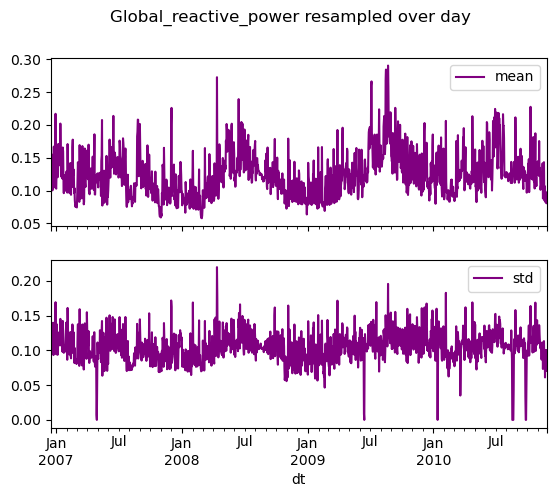

In [17]:
r2 = df.Global_reactive_power.resample('D').agg(['mean', 'std'])

r2.plot(subplots = True, title='Global_reactive_power resampled over day', color='purple')
plt.show()

- **Global_active_power**
- 한달 동안 샘플링된 'Global_active_power'의 sum

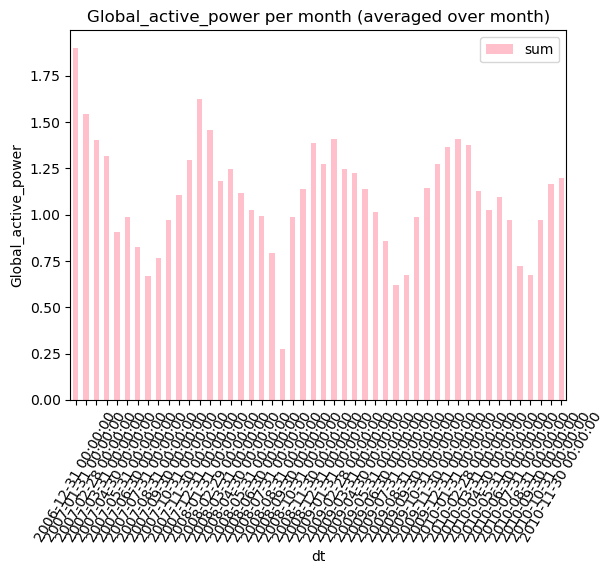

In [18]:
df['Global_active_power'].resample('M').mean().plot(kind='bar', label = "sum", color = "pink")

plt.xticks(rotation=60)
plt.ylabel('Global_active_power')

plt.title('Global_active_power per month (averaged over month)')
plt.legend()
plt.show()

- **Global_active_power**
- 분기별로 다시 샘플링된 'Global_active_power'의 mean

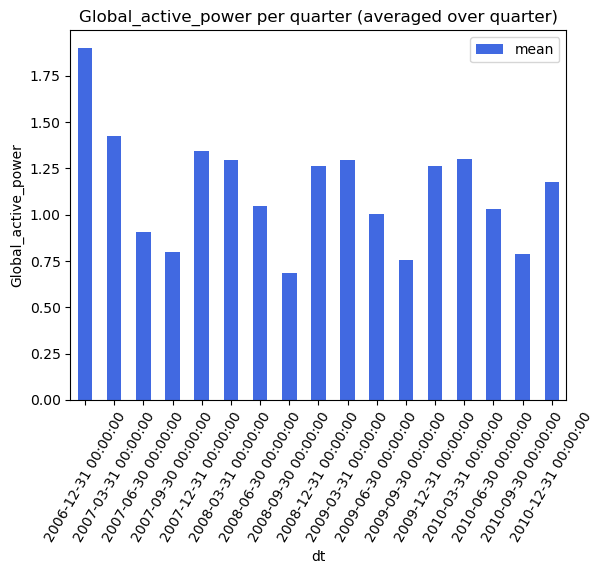

In [19]:
df['Global_active_power'].resample('Q').mean().plot(kind='bar', label = "mean", color = "royalblue")

plt.xticks(rotation=60)
plt.ylabel('Global_active_power')

plt.title('Global_active_power per quarter (averaged over quarter)')
plt.legend()
plt.show()

- **Voltage**
- 월에 걸쳐 샘플링된 'Voltage'의 mean

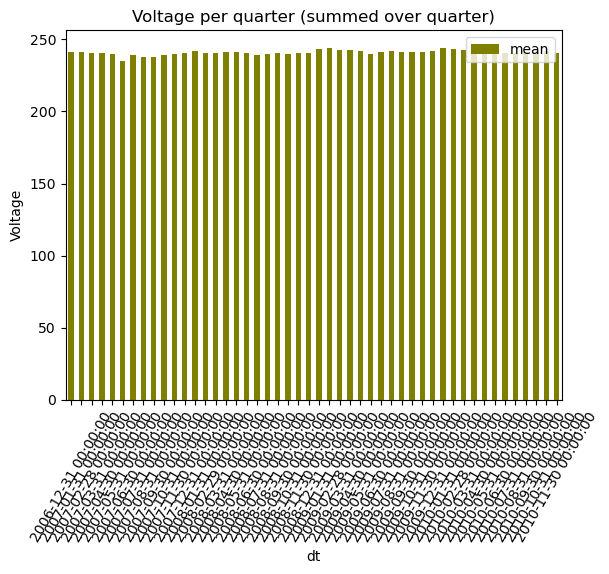

In [20]:
df['Voltage'].resample('M').mean().plot(kind='bar', label = "mean", color = "olive")

plt.xticks(rotation=60)
plt.ylabel('Voltage')

plt.title('Voltage per quarter (summed over quarter)')
plt.legend()
plt.show()

- **Sub_metering_1**
- 월에 걸쳐 샘플링된 'Sub_metering_1'의 mean

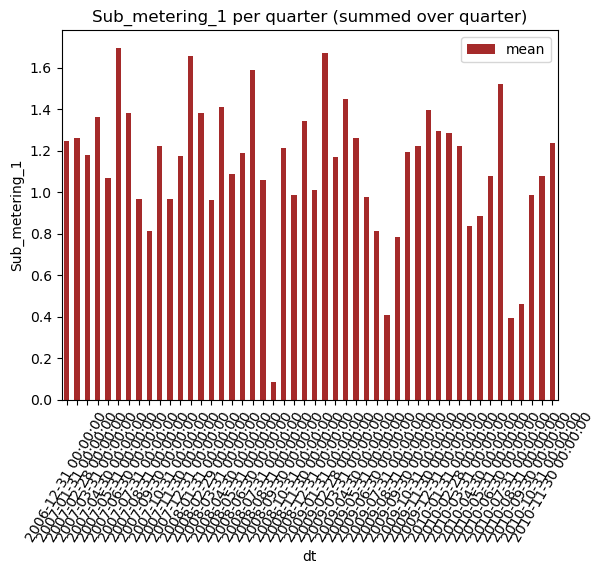

In [21]:
df['Sub_metering_1'].resample('M').mean().plot(kind='bar', label = "mean", color = "brown")

plt.xticks(rotation=60)
plt.ylabel('Sub_metering_1')

plt.title('Sub_metering_1 per quarter (summed over quarter)')
plt.legend()
plt.show()

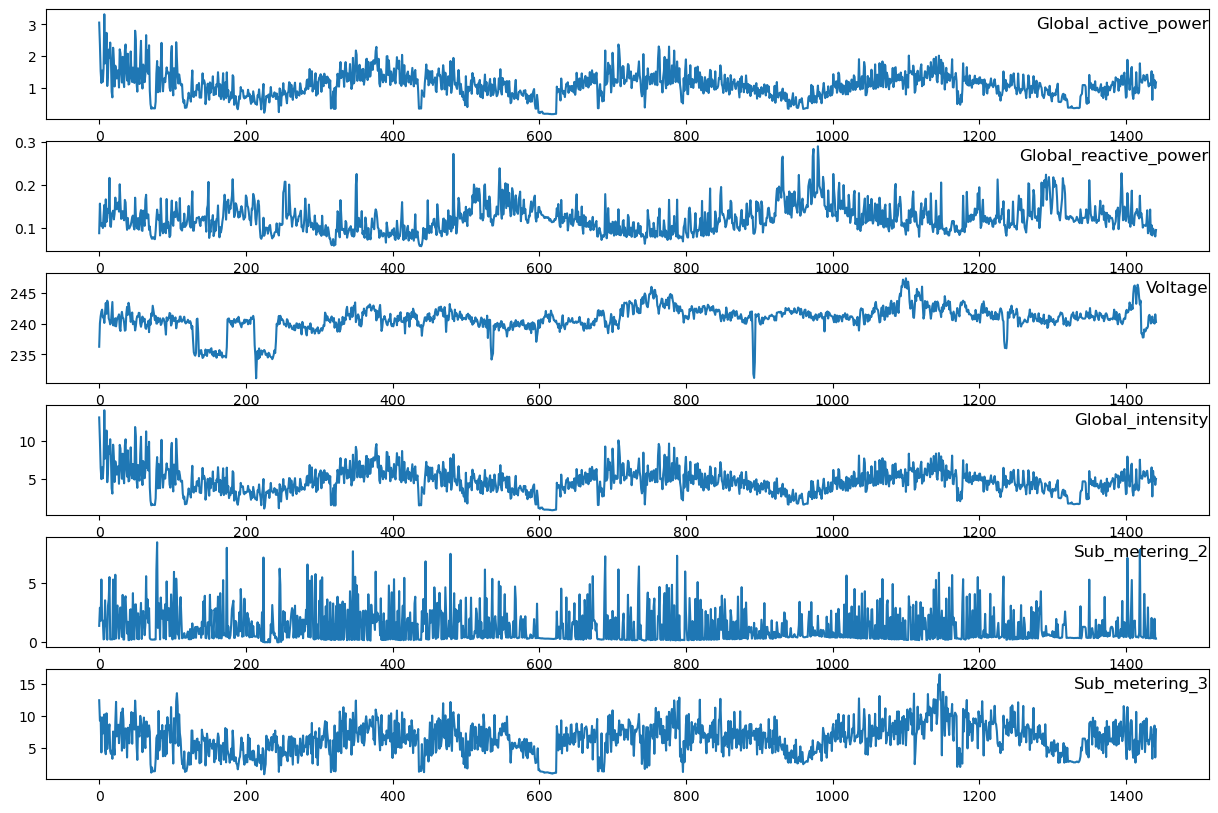

In [22]:
cols = [0, 1, 2, 3, 5, 6]
i = 1
groups=cols
values = df.resample('D').mean().values

# plot each column
plt.figure(figsize=(15, 10))
for group in groups:
	plt.subplot(len(cols), 1, i)
	plt.plot(values[:, group])
	plt.title(df.columns[group], y=0.75, loc='right')
	i += 1
plt.show()

- 일주일 동안 재샘플링 및 mean

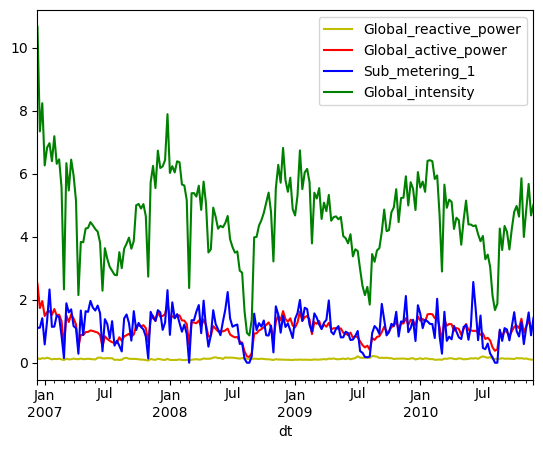

In [23]:
df.Global_reactive_power.resample('W').mean().plot(color='y', legend=True)
df.Global_active_power.resample('W').mean().plot(color='r', legend=True)
df.Sub_metering_1.resample('W').mean().plot(color='b', legend=True)
df.Global_intensity.resample('W').mean().plot(color='g', legend=True)

plt.show()

- 한 달에 걸쳐 재샘플링된 다른 특징의 mean에 대한 histogram

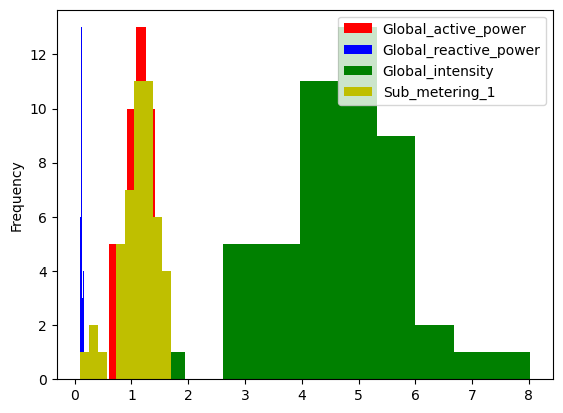

In [29]:
df.Global_active_power.resample('M').mean().plot(kind='hist', color='r', legend=True )
df.Global_reactive_power.resample('M').mean().plot(kind='hist',color='b', legend=True)
#df.Voltage.resample('M').sum().plot(kind='hist',color='g', legend=True)
df.Global_intensity.resample('M').mean().plot(kind='hist', color='g', legend=True)
df.Sub_metering_1.resample('M').mean().plot(kind='hist', color='y', legend=True)
plt.show()

- Global_intensity, Global_active_power의 상관관계
    - pct_change
        - 한 객체 내에서 행과 행의 차이를 현재값과의 백분율로 출력하는 메서드
        - (다음행 - 현재행) ÷ 현재행
        - (매도가격-매수가격)/매수가격 
        - 특정 N일에 대한 수익률을 구하고 싶다면 pct_change(periods=N)을 입력


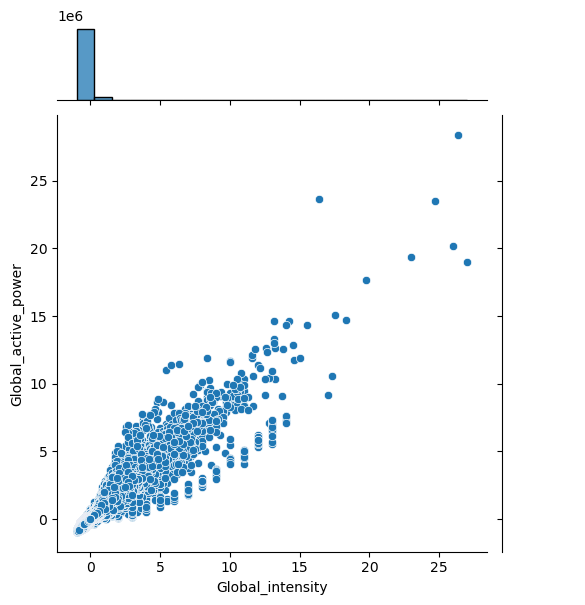

In [30]:
data_returns = df.pct_change()
sns.jointplot(x='Global_intensity', y='Global_active_power', data=data_returns)  

plt.show()

- Voltage'와 Global_active_power 사이의 상관 관계

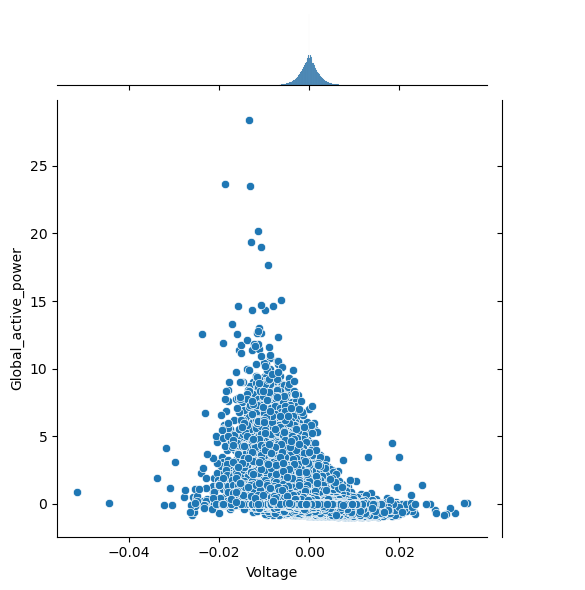

In [31]:
sns.jointplot(x='Voltage', y='Global_active_power', data=data_returns)  

plt.show()

#### 4. Correlations among features

- 열 간의 상관 관계

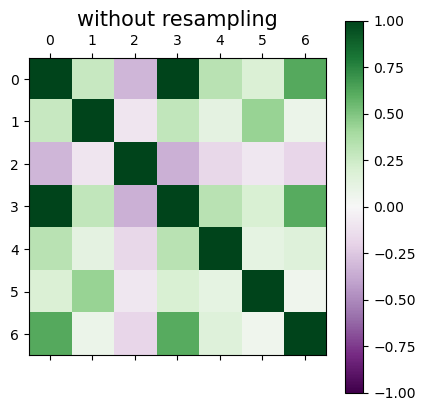

In [32]:
plt.matshow(df.corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('without resampling', size=15)
plt.colorbar()
plt.show()

- 몇 개월 동안 재샘플링된 특징의 mean 상관 관계

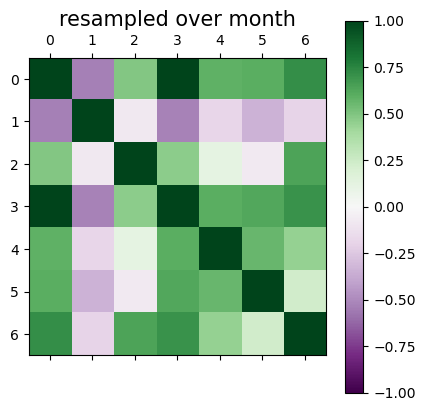

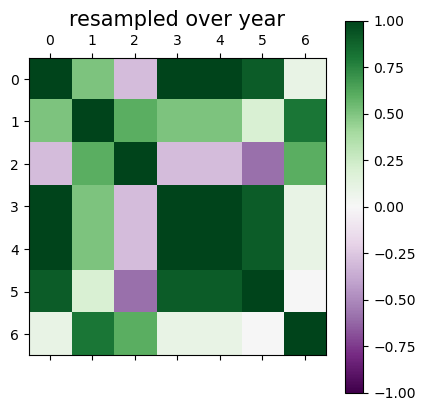

In [33]:
plt.matshow(df.resample('M').mean().corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('resampled over month', size=15)
plt.colorbar()
plt.margins(0.02)
plt.matshow(df.resample('A').mean().corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('resampled over year', size=15)
plt.colorbar()
plt.show()

#### 💙 Machine-Leaning: LSTM 

- 시계열과 순차적 문제에 가장 적합한 반복 신경망(LSTM)을 적용
    - 큰 데이터를 가지고 있다면 이 접근법이 최선
- 지도 학습 문제를 Global_active_power 측정 및 다른 기능이 주어진 현재 시간(t)에서 Global_active_power를 예측하는 것으로 프레임할 것

In [14]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

- 계산 시간을 단축하고 모델을 테스트할 수 있는 빠른 결과를 얻기 위해 시간 단위로 데이터를 재구성 (원래 데이터는 분 단위로 제공)
- 데이터의 크기가 2075259에서 34589로 줄어들지만, 데이터의 전체적인 구조는 유지된다.

In [15]:
## resampling of data over hour
df_resample = df.resample('h').mean() 
df_resample.shape

(34589, 7)

- [0,1] 범위의 모든 기능을 확장
- 재샘플링된 데이터(시간 이상)를 기반으로 훈련

In [16]:
values = df_resample.values 


## full data without resampling
#values = df.values

# integer encode direction
# ensure all data is float
#values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.636816   0.295738   0.337945   0.631157        0.0   0.011366   
2   0.545045   0.103358   0.335501   0.541487        0.0   0.144652   
3   0.509006   0.110073   0.283802   0.502152        0.0   0.030869   
4   0.488550   0.096987   0.315987   0.481110        0.0   0.000000   
5   0.455597   0.099010   0.434417   0.449904        0.0   0.008973   

   var7(t-1)   var1(t)  
1   0.782418  0.545045  
2   0.782676  0.509006  
3   0.774169  0.488550  
4   0.778809  0.455597  
5   0.798917  0.322555  


#### 💙 Splitting the rest of data to train and validation sets

- 준비된 데이터 세트를 train와 test set로 나눔
- 모델의 교육 속도를 높이기 위해 데이터 첫해에만 모델을 train 한 후 향후 3년 동안 데이터를 평가

In [17]:
# split into train and test sets
values = reframed.values

n_train_time = 365*24
train = values[:n_train_time, :]
test = values[n_train_time:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

(8760, 1, 7) (8760,) (25828, 1, 7) (25828,)


#### 💙 Model architecture

- 1) 첫 번째 visible layer 에 100개의 뉴런이 있는 LSTM
- 2) 20%를 dropout
- 3) Global_active_power를 예측하기 위한 output layer 의 뉴런 1개
- 4) Global_active_power를 예측하기 위한 output layer 의 뉴런 1개
- 5) 평균 절대 오차(MAE) 손실 함수와 확률적 경사 강하의 효율적인 Adam 버전을 사용

In [18]:
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))

model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

2022-09-20 13:33:20.592011: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-20 13:33:20.593226: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


- 6) 모델은 batch size가 70인 20개의 training epoch 에 적합할 것

In [19]:
# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/20
126/126 - 3s - loss: 0.0213 - val_loss: 0.0119 - 3s/epoch - 23ms/step
Epoch 2/20
126/126 - 1s - loss: 0.0127 - val_loss: 0.0109 - 974ms/epoch - 8ms/step
Epoch 3/20
126/126 - 1s - loss: 0.0116 - val_loss: 0.0101 - 1s/epoch - 8ms/step
Epoch 4/20
126/126 - 1s - loss: 0.0109 - val_loss: 0.0096 - 1s/epoch - 10ms/step
Epoch 5/20
126/126 - 2s - loss: 0.0107 - val_loss: 0.0092 - 2s/epoch - 16ms/step
Epoch 6/20
126/126 - 1s - loss: 0.0106 - val_loss: 0.0091 - 1s/epoch - 8ms/step
Epoch 7/20
126/126 - 2s - loss: 0.0105 - val_loss: 0.0092 - 2s/epoch - 12ms/step
Epoch 8/20
126/126 - 1s - loss: 0.0105 - val_loss: 0.0092 - 1s/epoch - 9ms/step
Epoch 9/20
126/126 - 1s - loss: 0.0104 - val_loss: 0.0092 - 1s/epoch - 9ms/step
Epoch 10/20
126/126 - 1s - loss: 0.0105 - val_loss: 0.0092 - 980ms/epoch - 8ms/step
Epoch 11/20
126/126 - 1s - loss: 0.0105 - val_loss: 0.0092 - 1s/epoch - 8ms/step
Epoch 12/20
126/126 - 1s - loss: 0.0105 - val_loss: 0.0092 - 1s/epoch - 9ms/step
Epoch 13/20
126/126 - 2s - 

- Loss 시각화

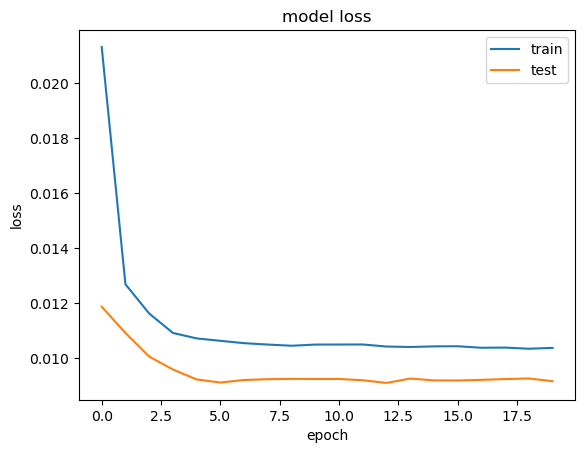

In [20]:
# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

- 예측하기 + RMSE

In [21]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 7))

# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.616


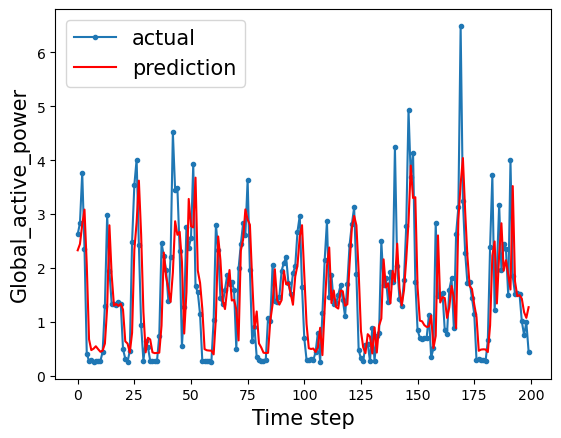

In [22]:
aa=[x for x in range(200)]

plt.plot(aa, inv_y[:200], marker='.', label="actual")
plt.plot(aa, inv_yhat[:200], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()